In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
import numpy as np 
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
test_images_f  = "t10k-images.idx3-ubyte"
test_labels_f  = "t10k-labels.idx1-ubyte"

In [3]:
train_images_f = "train-images.idx3-ubyte"
train_labels_f = "train-labels.idx1-ubyte"

In [4]:
class image_t(object):
    def __init__(self,pixels=None,label=None):
        self.pixels = pixels # 2D list of pixel values
        self.label  = label # alphanumeric value

    # print digit to terminal
    def output_terminal(self, threshold=20):
        if len(self.pixels)==784:
            line=[]
            for p in self.pixels:
                if int(p)>threshold: line.append(" X")
                else: line.append("  ")
                if len(line)==28:
                    print(''.join(line))
                    line=[]
            if self.label!=None: print("\nImage label = %s"%self.label)
        else:
            print("Image not 784 pixels!")

    # divide each entry by 255
    def normalize(self):
        for i in range(len(self.pixels)):
            self.pixels[i] = float(self.pixels[i])/255.0

    # create onehot vector for label
    def onehot_label(self):
        self.onehot = np.zeros(10)
        self.onehot[int(self.label)] = 1.0


In [5]:
# Read in num_words words starting at byte_offset. This is used for
# reading in the metadata of the file at the header.
def read_words(file, byte_offset, num_words):
    # Read a single word from a file and return the decimal representation
    def read_word(file, index):
        vals = []
        for i in range(4):
            file.seek(i+index)
            vals.append(ord(file.read(1)))
        val = vals[0]*(16**6) + vals[1]*(16**4) + vals[2]*(16**2) + vals[3]
        return val
    words = []
    for i in range(num_words):
        val = read_word(file, byte_offset+(i*4))
        words.append(val)
    return words

In [6]:
# Reads in num_bytes bytes starting at byte_offset
def read_bytes(file, byte_offset, num_bytes):
    vals = []
    for i in range(num_bytes):
        file.seek(byte_offset+i)
        vals.append(ord(file.read(1)))
    return vals

In [7]:
def get_images(file, byte_offset, num_images):
    pictures = []
    for i in range(num_images):
        pixels = read_bytes(file,byte_offset+(i*784),784)
        pictures.append(image_t(pixels))
    return pictures

In [8]:
def load_data(max_images=None):
    # load test image set
    with open(test_images_f,'rb') as f:
        magic,num_images,x_range,y_range = read_words(f,0,4)
        test_images = get_images(f,16,num_images if max_images is None else max_images)
    # load test image labels
    with open(test_labels_f,'rb') as f:
        test_labels = read_bytes(f,8,num_images)
    # correlate labels with images
    for t,l in zip(test_images,test_labels):
        t.label = l 
    
    # load train image set
    with open(train_images_f,'rb') as f:
        magic,num_images,x_range,y_range = read_words(f,0,4)
        train_images = get_images(f,16,num_images if max_images is None else max_images)
    # load train image labels
    with open(train_labels_f,'rb') as f:
        train_labels = read_bytes(f,8,num_images)
    # correlate labels with images
    for t,l in zip(train_images,train_labels):
        t.label = l 

    return test_images,train_images

In [9]:
def load_normalize_vectorize():
    print("Loading data...")
    test_images,train_images = load_data()

    print("Normalizing data...")
    for t in test_images:
        t.normalize()
        t.onehot_label()
    for t in train_images:
        t.normalize()
        t.onehot_label()

    print("Vectorizing data...")
    test_X=[]
    test_Y=[]
    train_X=[]
    train_Y=[]

    if K.image_data_format()=='channels_first':
        input_shape = (1,28,28)
    else:
        input_shape = (28,28,1)

    for t in test_images:
        test_X.append(np.array(t.pixels).reshape(input_shape))
        test_Y.append(t.onehot)
    for t in train_images:
        train_X.append(np.array(t.pixels).reshape(input_shape))
        train_Y.append(t.onehot)

    test_X = np.array(test_X)
    test_Y = np.array(test_Y)
    train_X = np.array(train_X)
    train_Y = np.array(train_Y)
    
    return test_X, test_Y, train_X, train_Y,input_shape

In [92]:
def main(kernel_size=(3,3),kernel_num=32,lr=1.0,active_func='relu'):
    
    print("Building model...")
    num_classes = 10
    batch_size = 128 
    epochs = 3

    model = Sequential()
    #first convolution layer
    model.add(Conv2D(kernel_num, kernel_size=kernel_size,activation=active_func,
                     input_shape=input_shape))
    #second convolution layer
    #model.add(Conv2D(kernel_num, kernel_size=kernel_size, activation=active_func))
    #third convolution layer
    #model.add(Conv2D(kernel_num, kernel_size=kernel_size, activation=active_func))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #dropout to prevent overfitting
    model.add(Dropout(0.25))
    model.add(Flatten())
    #fully-connected layers
    model.add(Dense(128, activation=active_func))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    print("Compiling model...")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(learning_rate=lr),
                  metrics=['accuracy'])

    print("Fitting model...")
    model.fit(train_X, train_Y,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(test_X, test_Y))
    score = model.evaluate(test_X, test_Y, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])


    return model

In [12]:
def save_model(model):
    print("Saving model...")
    model.save("conv2D_classifier.h5")
    print("Done.")

In [13]:
test_X, test_Y, train_X, train_Y,input_shape=load_normalize_vectorize()

Loading data...
Normalizing data...
Vectorizing data...


# Test for different kernel sizes

In [14]:
#kernel_size=(2,2)
if __name__ == '__main__':
    main(kernel_size=(2,2))

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 34s 574us/step - loss: 0.4186 - accuracy: 0.8722 - val_loss: 0.1486 - val_accuracy: 0.9528
Epoch 2/5
60000/60000 [==============================] - 38s 636us/step - loss: 0.2034 - accuracy: 0.9391 - val_loss: 0.1030 - val_accuracy: 0.9669
Epoch 3/5
60000/60000 [==============================] - 37s 621us/step - loss: 0.1574 - accuracy: 0.9534 - val_loss: 0.0803 - val_accuracy: 0.9742
Epoch 4/5
60000/60000 [==============================] - 36s 601us/step - loss: 0.1337 - accuracy: 0.9611 - val_loss: 0.0691 - val_accuracy: 0.9775
Epoch 5/5
60000/60000 [==============================] - 36s 605us/step - loss: 0.1180 - accuracy: 0.9650 - val_loss: 0.0650 - val_accuracy: 0.9798
Test loss: 0.06497711040060968
Test accuracy: 0.9797999858856201


In [67]:
test_accuracy1=[0.9528,0.9669,0.9742,0.9775,0.9798]

In [15]:
#kernel_size=(3,3)
if __name__ == '__main__':
    main(kernel_size=(3,3))

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 37s 619us/step - loss: 0.3633 - accuracy: 0.8896 - val_loss: 0.0974 - val_accuracy: 0.9715
Epoch 2/5
60000/60000 [==============================] - 37s 625us/step - loss: 0.1431 - accuracy: 0.9586 - val_loss: 0.0688 - val_accuracy: 0.9779
Epoch 3/5
60000/60000 [==============================] - 37s 623us/step - loss: 0.1059 - accuracy: 0.9680 - val_loss: 0.0592 - val_accuracy: 0.9800
Epoch 4/5
60000/60000 [==============================] - 36s 602us/step - loss: 0.0898 - accuracy: 0.9735 - val_loss: 0.0503 - val_accuracy: 0.9830
Epoch 5/5
60000/60000 [==============================] - 36s 604us/step - loss: 0.0784 - accuracy: 0.9768 - val_loss: 0.0455 - val_accuracy: 0.9839
Test loss: 0.045497187581774776
Test accuracy: 0.9839000105857849


In [68]:
test_accuracy2=[0.9715,0.9779,0.9800,0.9830,0.9839]

In [16]:
#kernel_size=(4,4)
if __name__ == '__main__':
    main(kernel_size=(4,4))

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 34s 574us/step - loss: 0.3497 - accuracy: 0.8942 - val_loss: 0.0899 - val_accuracy: 0.9716
Epoch 2/5
60000/60000 [==============================] - 34s 564us/step - loss: 0.1317 - accuracy: 0.9621 - val_loss: 0.0583 - val_accuracy: 0.9815
Epoch 3/5
60000/60000 [==============================] - 34s 567us/step - loss: 0.1009 - accuracy: 0.9698 - val_loss: 0.0474 - val_accuracy: 0.9838
Epoch 4/5
60000/60000 [==============================] - 34s 570us/step - loss: 0.0824 - accuracy: 0.9756 - val_loss: 0.0430 - val_accuracy: 0.9849
Epoch 5/5
60000/60000 [==============================] - 34s 570us/step - loss: 0.0733 - accuracy: 0.9781 - val_loss: 0.0392 - val_accuracy: 0.9858
Test loss: 0.039196522748452846
Test accuracy: 0.98580002784729


In [69]:
test_accuracy3=[0.9716,0.9815,0.9838,0.9849,0.9858]

In [17]:
#kernel_size=(5,5)
if __name__ == '__main__':
    main(kernel_size=(5,5))

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 35s 582us/step - loss: 0.3037 - accuracy: 0.9072 - val_loss: 0.0849 - val_accuracy: 0.9746
Epoch 2/5
60000/60000 [==============================] - 37s 609us/step - loss: 0.1165 - accuracy: 0.9655 - val_loss: 0.0520 - val_accuracy: 0.9833
Epoch 3/5
60000/60000 [==============================] - 37s 611us/step - loss: 0.0886 - accuracy: 0.9734 - val_loss: 0.0417 - val_accuracy: 0.9859
Epoch 4/5
60000/60000 [==============================] - 36s 605us/step - loss: 0.0734 - accuracy: 0.9782 - val_loss: 0.0406 - val_accuracy: 0.9865
Epoch 5/5
60000/60000 [==============================] - 36s 608us/step - loss: 0.0642 - accuracy: 0.9807 - val_loss: 0.0359 - val_accuracy: 0.9874
Test loss: 0.03588931858259602
Test accuracy: 0.9873999953269958


In [70]:
test_accuracy4=[0.9746,0.9833,0.9859,0.9865,0.9874]

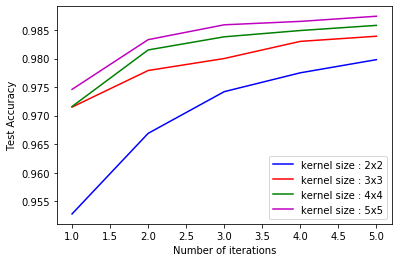

In [71]:
plt.plot([1,2,3,4,5],test_accuracy1,color='b')
plt.plot([1,2,3,4,5],test_accuracy2,color='r')
plt.plot([1,2,3,4,5],test_accuracy3,color='g')
plt.plot([1,2,3,4,5],test_accuracy4,color='m')
plt.ylabel('Test Accuracy')
plt.xlabel('Number of iterations')
plt.legend(['kernel size : 2x2','kernel size : 3x3','kernel size : 4x4','kernel size : 5x5'])
plt.show()

# Test for different kernel numbers

In [23]:
# kernel_number = 32
if __name__ == '__main__':
    main(kernel_num=32)

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 41s 685us/step - loss: 0.3919 - accuracy: 0.8802 - val_loss: 0.1228 - val_accuracy: 0.9631
Epoch 2/5
60000/60000 [==============================] - 39s 645us/step - loss: 0.1581 - accuracy: 0.9541 - val_loss: 0.0707 - val_accuracy: 0.9783
Epoch 3/5
60000/60000 [==============================] - 43s 714us/step - loss: 0.1108 - accuracy: 0.9678 - val_loss: 0.0572 - val_accuracy: 0.9809
Epoch 4/5
60000/60000 [==============================] - 41s 681us/step - loss: 0.0938 - accuracy: 0.9722 - val_loss: 0.0507 - val_accuracy: 0.9830
Epoch 5/5
60000/60000 [==============================] - 42s 701us/step - loss: 0.0812 - accuracy: 0.9753 - val_loss: 0.0466 - val_accuracy: 0.9829
Test loss: 0.0466205170115456
Test accuracy: 0.9829000234603882


In [72]:
test_accuracy1=[0.9631,0.9783,0.9809,0.9830,0.9829]

In [24]:
# kernel_number = 64
if __name__ == '__main__':
    main(kernel_num=64)

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 68s 1ms/step - loss: 0.3397 - accuracy: 0.8966 - val_loss: 0.0994 - val_accuracy: 0.9689
Epoch 2/5
60000/60000 [==============================] - 79s 1ms/step - loss: 0.1290 - accuracy: 0.9618 - val_loss: 0.0641 - val_accuracy: 0.9787
Epoch 3/5
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0968 - accuracy: 0.9717 - val_loss: 0.0510 - val_accuracy: 0.9833
Epoch 4/5
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0789 - accuracy: 0.9764 - val_loss: 0.0485 - val_accuracy: 0.9829
Epoch 5/5
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0711 - accuracy: 0.9788 - val_loss: 0.0415 - val_accuracy: 0.9854
Test loss: 0.041494555433106144
Test accuracy: 0.9854000210762024


In [73]:
test_accuracy2=[0.9689,0.9787,0.9833,0.9829,0.9854]

In [25]:
# kernel_number = 128
if __name__ == '__main__':
    main(kernel_num=128)

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 115s 2ms/step - loss: 0.3379 - accuracy: 0.8972 - val_loss: 0.0942 - val_accuracy: 0.9707
Epoch 2/5
60000/60000 [==============================] - 113s 2ms/step - loss: 0.1271 - accuracy: 0.9625 - val_loss: 0.0603 - val_accuracy: 0.9812
Epoch 3/5
60000/60000 [==============================] - 115s 2ms/step - loss: 0.0921 - accuracy: 0.9727 - val_loss: 0.0474 - val_accuracy: 0.9840
Epoch 4/5
60000/60000 [==============================] - 114s 2ms/step - loss: 0.0750 - accuracy: 0.9771 - val_loss: 0.0427 - val_accuracy: 0.9847
Epoch 5/5
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0663 - accuracy: 0.9799 - val_loss: 0.0439 - val_accuracy: 0.9854
Test loss: 0.0439450320716016
Test accuracy: 0.9854000210762024


In [74]:
test_accuracy3=[0.9707,0.9812,0.9840,0.9847,0.9854]

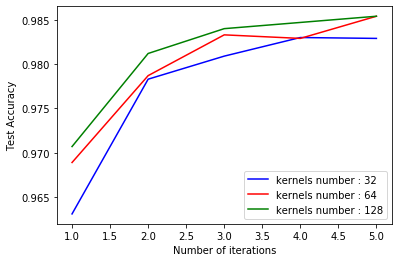

In [75]:
plt.plot([1,2,3,4,5],test_accuracy1,color='b')
plt.plot([1,2,3,4,5],test_accuracy2,color='r')
plt.plot([1,2,3,4,5],test_accuracy3,color='g')
plt.ylabel('Test Accuracy')
plt.xlabel('Number of iterations')
plt.legend(['kernels number : 32','kernels number : 64','kernels number : 128'])
plt.show()

# Test for different Learning rate values

In [30]:
# learning rate = 0.1
if __name__ == '__main__':
    main(lr=0.1)

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 34s 562us/step - loss: 0.7765 - accuracy: 0.7739 - val_loss: 0.3065 - val_accuracy: 0.9151
Epoch 2/5
60000/60000 [==============================] - 35s 587us/step - loss: 0.3861 - accuracy: 0.8863 - val_loss: 0.2358 - val_accuracy: 0.9333
Epoch 3/5
60000/60000 [==============================] - 35s 589us/step - loss: 0.3228 - accuracy: 0.9034 - val_loss: 0.1975 - val_accuracy: 0.9417
Epoch 4/5
60000/60000 [==============================] - 36s 595us/step - loss: 0.2888 - accuracy: 0.9157 - val_loss: 0.1725 - val_accuracy: 0.9492
Epoch 5/5
60000/60000 [==============================] - 36s 593us/step - loss: 0.2619 - accuracy: 0.9227 - val_loss: 0.1570 - val_accuracy: 0.9534
Test loss: 0.15701893895417451
Test accuracy: 0.9534000158309937


In [76]:
test_accuracy1=[0.9151,0.9333,0.9417,0.9492,0.9534]

In [31]:
# learning rate = 1
if __name__ == '__main__':
    main(lr=1)

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 35s 584us/step - loss: 0.3504 - accuracy: 0.8943 - val_loss: 0.1032 - val_accuracy: 0.9686
Epoch 2/5
60000/60000 [==============================] - 35s 586us/step - loss: 0.1435 - accuracy: 0.9573 - val_loss: 0.0680 - val_accuracy: 0.9774
Epoch 3/5
60000/60000 [==============================] - 35s 588us/step - loss: 0.1105 - accuracy: 0.9666 - val_loss: 0.0565 - val_accuracy: 0.9826
Epoch 4/5
60000/60000 [==============================] - 35s 586us/step - loss: 0.0928 - accuracy: 0.9731 - val_loss: 0.0496 - val_accuracy: 0.9828
Epoch 5/5
60000/60000 [==============================] - 35s 592us/step - loss: 0.0813 - accuracy: 0.9753 - val_loss: 0.0466 - val_accuracy: 0.9841
Test loss: 0.04664903507290874
Test accuracy: 0.9840999841690063


In [77]:
test_accuracy2=[0.9686,0.9774,0.9826,0.9828,0.9841]

In [32]:
# learning rate = 10
if __name__ == '__main__':
    main(lr=10)

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 36s 600us/step - loss: 0.2653 - accuracy: 0.9193 - val_loss: 0.0879 - val_accuracy: 0.9723
Epoch 2/5
60000/60000 [==============================] - 36s 601us/step - loss: 0.1211 - accuracy: 0.9639 - val_loss: 0.0614 - val_accuracy: 0.9819
Epoch 3/5
60000/60000 [==============================] - 35s 584us/step - loss: 0.0953 - accuracy: 0.9719 - val_loss: 0.0561 - val_accuracy: 0.9828
Epoch 4/5
60000/60000 [==============================] - 35s 583us/step - loss: 0.0800 - accuracy: 0.9762 - val_loss: 0.0507 - val_accuracy: 0.9839
Epoch 5/5
60000/60000 [==============================] - 35s 583us/step - loss: 0.0725 - accuracy: 0.9786 - val_loss: 0.0463 - val_accuracy: 0.9867
Test loss: 0.04625659216317145
Test accuracy: 0.9866999983787537


In [78]:
test_accuracy3=[0.9723,0.9819,0.9828,0.9839,0.9867]

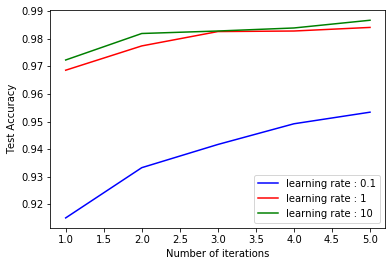

In [79]:
plt.plot([1,2,3,4,5],test_accuracy1,color='b')
plt.plot([1,2,3,4,5],test_accuracy2,color='r')
plt.plot([1,2,3,4,5],test_accuracy3,color='g')
plt.ylabel('Test Accuracy')
plt.xlabel('Number of iterations')
plt.legend(['learning rate : 0.1','learning rate : 1','learning rate : 10'])
plt.show()

# Test for different activation functions

In [33]:
#activation function : sigmoid
if __name__ == '__main__':
    main(active_func='sigmoid')

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 36s 596us/step - loss: 2.0544 - accuracy: 0.2374 - val_loss: 0.9005 - val_accuracy: 0.6837
Epoch 2/5
60000/60000 [==============================] - 36s 593us/step - loss: 0.5708 - accuracy: 0.8275 - val_loss: 0.3743 - val_accuracy: 0.8788
Epoch 3/5
60000/60000 [==============================] - 38s 640us/step - loss: 0.3833 - accuracy: 0.8871 - val_loss: 0.2520 - val_accuracy: 0.9230
Epoch 4/5
60000/60000 [==============================] - 41s 684us/step - loss: 0.3215 - accuracy: 0.9039 - val_loss: 0.2108 - val_accuracy: 0.9363
Epoch 5/5
60000/60000 [==============================] - 38s 630us/step - loss: 0.2823 - accuracy: 0.9155 - val_loss: 0.1753 - val_accuracy: 0.9458
Test loss: 0.1753128852546215
Test accuracy: 0.9458000063896179


In [80]:
test_accuracy1=[0.6837,0.8788,0.9230,0.9363,0.9458]

In [34]:
#activation function : relu
if __name__ == '__main__':
    main(active_func='relu')

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 37s 616us/step - loss: 0.3721 - accuracy: 0.8859 - val_loss: 0.1096 - val_accuracy: 0.9661
Epoch 2/5
60000/60000 [==============================] - 38s 626us/step - loss: 0.1549 - accuracy: 0.9542 - val_loss: 0.0714 - val_accuracy: 0.9785
Epoch 3/5
60000/60000 [==============================] - 36s 603us/step - loss: 0.1137 - accuracy: 0.9655 - val_loss: 0.0591 - val_accuracy: 0.9808
Epoch 4/5
60000/60000 [==============================] - 35s 588us/step - loss: 0.0977 - accuracy: 0.9703 - val_loss: 0.0515 - val_accuracy: 0.9832
Epoch 5/5
60000/60000 [==============================] - 36s 598us/step - loss: 0.0864 - accuracy: 0.9737 - val_loss: 0.0483 - val_accuracy: 0.9843
Test loss: 0.048261129591963256
Test accuracy: 0.9843000173568726


In [81]:
test_accuracy2=[0.9661,0.9785,0.9808,0.9832,0.9843]

In [35]:
#activation function : tanh
if __name__ == '__main__':
    main(active_func='tanh')

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 36s 600us/step - loss: 0.3364 - accuracy: 0.8985 - val_loss: 0.1513 - val_accuracy: 0.9542
Epoch 2/5
60000/60000 [==============================] - 36s 601us/step - loss: 0.1632 - accuracy: 0.9513 - val_loss: 0.1028 - val_accuracy: 0.9686
Epoch 3/5
60000/60000 [==============================] - 37s 619us/step - loss: 0.1293 - accuracy: 0.9605 - val_loss: 0.0771 - val_accuracy: 0.9755
Epoch 4/5
60000/60000 [==============================] - 38s 626us/step - loss: 0.1094 - accuracy: 0.9668 - val_loss: 0.0809 - val_accuracy: 0.9749
Epoch 5/5
60000/60000 [==============================] - 37s 618us/step - loss: 0.0984 - accuracy: 0.9693 - val_loss: 0.0626 - val_accuracy: 0.9801
Test loss: 0.06259014640524983
Test accuracy: 0.9800999760627747


In [82]:
test_accuracy3=[0.9542,0.9686,0.9755,0.9749,0.9801]

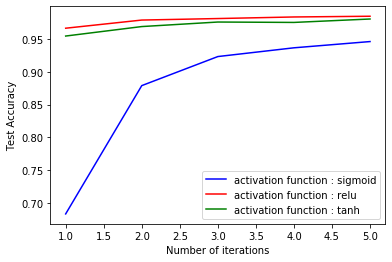

In [83]:
plt.plot([1,2,3,4,5],test_accuracy1,color='b')
plt.plot([1,2,3,4,5],test_accuracy2,color='r')
plt.plot([1,2,3,4,5],test_accuracy3,color='g')
plt.ylabel('Test Accuracy')
plt.xlabel('Number of iterations')
plt.legend(['activation function : sigmoid','activation function : relu','activation function : tanh'])
plt.show()

# Test for different layers numbers

In [44]:
# one convolutional layer
if __name__ == '__main__':
    main()

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 39s 653us/step - loss: 0.3479 - accuracy: 0.8943 - val_loss: 0.1055 - val_accuracy: 0.9687
Epoch 2/5
60000/60000 [==============================] - 37s 624us/step - loss: 0.1395 - accuracy: 0.9589 - val_loss: 0.0662 - val_accuracy: 0.9800
Epoch 3/5
60000/60000 [==============================] - 38s 626us/step - loss: 0.1046 - accuracy: 0.9690 - val_loss: 0.0574 - val_accuracy: 0.9813
Epoch 4/5
60000/60000 [==============================] - 39s 645us/step - loss: 0.0899 - accuracy: 0.9733 - val_loss: 0.0500 - val_accuracy: 0.9831
Epoch 5/5
60000/60000 [==============================] - 39s 654us/step - loss: 0.0786 - accuracy: 0.9770 - val_loss: 0.0473 - val_accuracy: 0.9831
Test loss: 0.047344619320670606
Test accuracy: 0.9830999970436096


In [84]:
test_accuracy1=[0.9687,0.9800,0.9813,0.9831,0.9831]

In [52]:
# two convolutional layer
if __name__ == '__main__':
    main()

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 97s 2ms/step - loss: 0.2955 - accuracy: 0.9088 - val_loss: 0.0675 - val_accuracy: 0.9783
Epoch 2/5
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0992 - accuracy: 0.9706 - val_loss: 0.0422 - val_accuracy: 0.9855
Epoch 3/5
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0747 - accuracy: 0.9775 - val_loss: 0.0340 - val_accuracy: 0.9887
Epoch 4/5
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0627 - accuracy: 0.9815 - val_loss: 0.0312 - val_accuracy: 0.9894
Epoch 5/5
60000/60000 [==============================] - 89s 1ms/step - loss: 0.0542 - accuracy: 0.9842 - val_loss: 0.0290 - val_accuracy: 0.9900
Test loss: 0.028990731894140483
Test accuracy: 0.9900000095367432


In [85]:
test_accuracy2=[0.9783,0.9855,0.9887,0.9894,0.9900]

In [55]:
# three convolutional layer
if __name__ == '__main__':
    main()

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 128s 2ms/step - loss: 0.2758 - accuracy: 0.9158 - val_loss: 0.0588 - val_accuracy: 0.9821
Epoch 2/5
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0916 - accuracy: 0.9722 - val_loss: 0.0436 - val_accuracy: 0.9859
Epoch 3/5
60000/60000 [==============================] - 133s 2ms/step - loss: 0.0678 - accuracy: 0.9797 - val_loss: 0.0355 - val_accuracy: 0.9873
Epoch 4/5
60000/60000 [==============================] - 139s 2ms/step - loss: 0.0578 - accuracy: 0.9833 - val_loss: 0.0291 - val_accuracy: 0.9896
Epoch 5/5
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0508 - accuracy: 0.9847 - val_loss: 0.0290 - val_accuracy: 0.9905
Test loss: 0.029020933232097014
Test accuracy: 0.9904999732971191


In [86]:
test_accuracy3=[0.9821,0.9859,0.9873, 0.9896,0.9905]

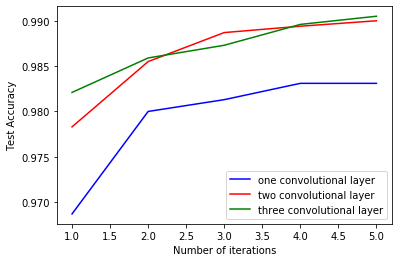

In [87]:
plt.plot([1,2,3,4,5],test_accuracy1,color='b')
plt.plot([1,2,3,4,5],test_accuracy2,color='r')
plt.plot([1,2,3,4,5],test_accuracy3,color='g')
plt.ylabel('Test Accuracy')
plt.xlabel('Number of iterations')
plt.legend(['one convolutional layer','two convolutional layer','three convolutional layer'])
plt.show()

In [93]:
#saving a model with best parameters gained - three layer convolution with parameters below
if __name__ == '__main__':
    model=main(kernel_size=(5,5),kernel_num=128,lr=10,active_func='relu')
    save_model(model)
# for saving time i saved the model with best parameters and one convolution layer 

Building model...
Compiling model...
Fitting model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 111s 2ms/step - loss: 0.3087 - accuracy: 0.9074 - val_loss: 0.0640 - val_accuracy: 0.9798
Epoch 2/3
60000/60000 [==============================] - 108s 2ms/step - loss: 0.1283 - accuracy: 0.9637 - val_loss: 0.0525 - val_accuracy: 0.9830
Epoch 3/3
60000/60000 [==============================] - 112s 2ms/step - loss: 0.1058 - accuracy: 0.9699 - val_loss: 0.0484 - val_accuracy: 0.9851
Test loss: 0.048352208137250274
Test accuracy: 0.9850999712944031
Saving model...
Done.


# visualizing filters 

In [99]:
filters,biases=model.layers[0].get_weights()

In [100]:
#normalize filters
#filters are 5x5
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

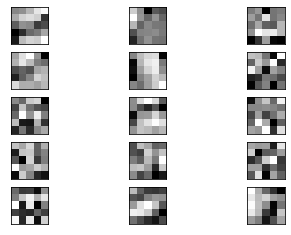

In [101]:
#visualize first 15 filters
n_filters, ix = 15, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    ax = plt.subplot(n_filters/3, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :,0],cmap='gray')
    ix += 1
# show the figure
plt.show()